# Kết nối drive & import thư viện

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from google.colab import drive
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [3]:
print("--> 🔌 Đang kết nối Google Drive...")
drive.mount('/content/gdrive')

--> 🔌 Đang kết nối Google Drive...
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Chuẩn bị dữ liệu

In [4]:
#PATH_ROOT = '/content/drive/MyDrive/DWT'
PATH_ROOT = '/content/gdrive/MyDrive/PAPER HN/Snoring problem/Data/DWT'

In [5]:
print(f"\n📂 Đang kiểm tra thư mục: {PATH_ROOT}")
if os.path.exists(PATH_ROOT):
    print(f"✅ Đã tìm thấy! Bên trong có: {os.listdir(PATH_ROOT)}")
else:
    print("❌ LỖI: Không tìm thấy folder DWT. Kiểm tra lại Drive!")


📂 Đang kiểm tra thư mục: /content/gdrive/MyDrive/PAPER HN/Snoring problem/Data/DWT
✅ Đã tìm thấy! Bên trong có: ['normal-snore', 'osa-snore', 'others']


In [6]:
def load_data_from_drive(folder_name, label):
    data = []
    labels = []
    full_path = os.path.join(PATH_ROOT, folder_name)

    print(f"--> ⏳ Đang đọc folder: '{folder_name}' ...")

    if not os.path.exists(full_path):
        print(f"❌ LỖI: Không tìm thấy folder '{folder_name}'!")
        return np.array([]), np.array([])

    file_list = os.listdir(full_path)
    count = 0
    err_count = 0

    for filename in file_list:
        if filename.endswith('.npy'):
            try:
                img = np.load(os.path.join(full_path, filename), allow_pickle=True)

                # Chấp nhận kích thước thật của file là (100, 64)
                if img.shape == (100, 64):
                    data.append(img)
                    labels.append(label)
                    count += 1
                else:
                    err_count += 1
            except:
                pass

    print(f"    ✅ Đã tải: {count} mẫu.")
    if err_count > 0:
        print(f"    ⚠️ Đã bỏ qua {err_count} file do sai kích thước (Khác 100x64).")

    return np.array(data), np.array(labels)

In [7]:
X_osa, y_osa = load_data_from_drive("osa-snore", 0)
X_norm, y_norm = load_data_from_drive("normal-snore", 1)
X_other, y_other = load_data_from_drive("others", 2)

--> ⏳ Đang đọc folder: 'osa-snore' ...
    ✅ Đã tải: 500 mẫu.
--> ⏳ Đang đọc folder: 'normal-snore' ...
    ✅ Đã tải: 500 mẫu.
--> ⏳ Đang đọc folder: 'others' ...
    ✅ Đã tải: 500 mẫu.


In [8]:
X = np.concatenate((X_osa, X_norm, X_other), axis=0)
y = np.concatenate((y_osa, y_norm, y_other), axis=0)

In [9]:
X = X.reshape(X.shape[0], 100, 64, 1)
y = to_categorical(y, num_classes=3)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.176, random_state=42)

# Build model

## Model tự tạo

In [ ]:
model = Sequential()

# Input shape sửa thành (100, 64, 1)
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(100, 64, 1)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## LeNet5

In [ ]:
model_lenet5 = Sequential()

model_lenet5.add(Conv2D(filters=6, kernel_size=(5, 5), activation='relu', input_shape=(100, 64, 1)))
model_lenet5.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model_lenet5.add(Conv2D(filters=16, kernel_size=(5, 5), activation='relu'))
model_lenet5.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model_lenet5.add(Flatten())

model_lenet5.add(Dense(units=120, activation='relu'))
model_lenet5.add(Dense(units=84, activation='relu'))
model_lenet5.add(Dense(units=3, activation='softmax'))

model_lenet5.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## EfficientNetB5

In [11]:
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras.layers import Dense, Flatten, Input, Layer
from tensorflow.keras.models import Model
import tensorflow as tf

# Define a custom Keras Layer to convert 1 channel to 3 channels using tf.tile
class GrayscaleToRGB(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, inputs):
        # inputs is a KerasTensor of shape (batch_size, height, width, 1)
        # We need to tile along the last axis (channel axis) 3 times
        return tf.tile(inputs, [1, 1, 1, 3])

    def get_config(self):
        config = super().get_config()
        return config

# Let's create a Keras Input layer matching the data's shape
input_layer = Input(shape=(100, 64, 1))

# Use the custom layer to convert 1-channel input to 3 channels
three_channel_input = GrayscaleToRGB()(input_layer)

# Load EfficientNetB5 model with ImageNet weights, excluding the top (classification) layer
# and specifying the modified input tensor for the feature extractor.
# The `input_tensor` argument expects a Keras tensor, which `three_channel_input` now is.
base_model = EfficientNetB5(weights='imagenet', include_top=False, input_tensor=three_channel_input)

# Add custom top layers for our classification task
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dense(3, activation='softmax')(x) # 3 classes for OSA, Normal, Others

# Create the full model, ensuring the input is `input_layer` (the original 1-channel input)
# and the output is `x`.
model_efficientnetb5 = Model(inputs=input_layer, outputs=x)

# Freeze the base model layers to prevent re-training them initially
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model_efficientnetb5.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_efficientnetb5.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100, 64,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ grayscale_to_rgb    │ (None, 100, 64,   │          0 │ input_layer[0][0] │
│ (GrayscaleToRGB)    │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 100, 64,   │          0 │ grayscale_to_rgb… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 100, 64,   │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 100, 64,   │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 101, 65,   │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 50, 32,    │      1,296 │ stem_conv_pad[0]… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 50, 32,    │        192 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 50, 32,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 50, 32,    │        432 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 50, 32,    │        192 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 50, 32,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 48)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 48)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 12)  │        588 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 48)  │        624 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 50, 32,    │          0 │ block1a_activati

 Total params: 30,611,194 (116.77 MB)

 Trainable params: 2,097,667 (8.00 MB)

 Non-trainable params: 28,513,527 (108.77 MB)

# Huấn luyện mô hình

In [12]:
print("\n🚀 ĐANG HUẤN LUYỆN MODEL...")
#history = model_lenet5.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), verbose=1)
history = model_efficientnetb5.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), verbose=1)


🚀 ĐANG HUẤN LUYỆN MODEL...
Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 143s 3s/step - accuracy: 0.2865 - loss: 8.1245 - val_accuracy: 0.3289 - val_loss: 1.0901
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.4015 - loss: 1.0917 - val_accuracy: 0.3956 - val_loss: 1.0824
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.4097 - loss: 1.0789 - val_accuracy: 0.4533 - val_loss: 1.0814
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.4220 - loss: 1.0740 - val_accuracy: 0.3956 - val_loss: 1.0660
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.4305 - loss: 1.0518 - val_accuracy: 0.5022 - val_loss: 1.0536
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.4515 - loss: 1.0575 - val_accuracy: 0.4578 - val_loss: 1.0648
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.4358 - loss: 1.0671 - val_accuracy: 0.4400 - val_loss: 1.0508
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.4547 - los

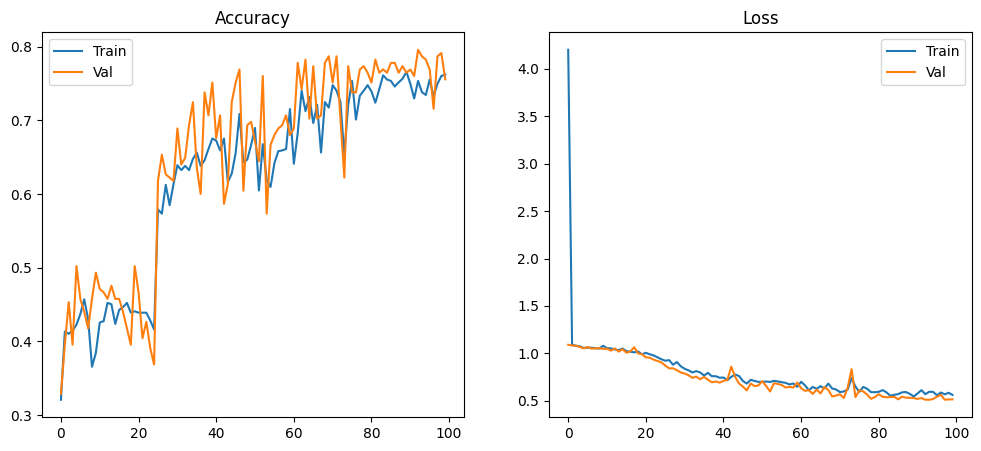

In [13]:
# Vẽ biểu đồ
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss')
plt.legend()
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step


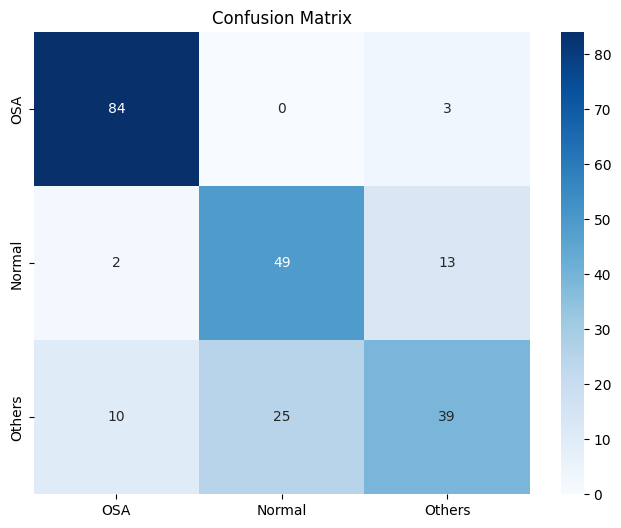


✅ ĐÃ HOÀN TẤT!


In [14]:
# Ma trận nhầm lẫn
y_pred = np.argmax(model_efficientnetb5.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
classes = ['OSA', 'Normal', 'Others']

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(pd.DataFrame(cm, index=classes, columns=classes), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

model_efficientnetb5.save('Model_EFF5_PhatHienNgay_100x64.h5')
print("\n✅ ĐÃ HOÀN TẤT!")

In [15]:
def in_ket_qua_danh_gia(y_true, y_pred):
    """
    Hàm này dùng để in ra các chỉ số đánh giá mà không cần sửa code cũ.
    """
    from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

    print("\n" + "="*30)
    print("BẢNG KẾT QUẢ ĐÁNH GIÁ:")
    print("="*30)

    # 1. Accuracy
    acc = accuracy_score(y_true, y_pred)
    print(f'Accuracy  : {acc:.4f}')

    # 2. Precision
    pre = precision_score(y_true, y_pred, average='macro', zero_division=0)
    print(f'Precision : {pre:.4f}')

    # 3. Recall
    rec = recall_score(y_true, y_pred, average='macro', zero_division=0)
    print(f'Recall    : {rec:.4f}')

    # 4. F1 Score
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    print(f'F1 score  : {f1:.4f}')
    print("="*30 + "\n")

In [16]:
in_ket_qua_danh_gia(y_true, y_pred)


BẢNG KẾT QUẢ ĐÁNH GIÁ:
Accuracy  : 0.7644
Precision : 0.7488
Recall    : 0.7527
F1 score  : 0.7443

